In [35]:
import networkx as nx
import os
from pathlib import Path
import pandas as pd
import numpy as np
import math

switch = 1 # prevent accidental cell executions

In [ ]:
# setup

xferpath = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\cleaned")
recpath = Path(r"C:\Users\User\Documents\cfb project\data\recruiting")
xferfiles = {}
recfiles = {}

for file_path in xferpath.glob('*.graphml'):
    name = file_path.stem
    G_x = nx.read_graphml(file_path)
    xferfiles[name] = G_x

for file_path in recpath.glob('*.graphml'):
    name = file_path.stem
    G_r = nx.read_graphml(file_path)
    recfiles[name] = G_r

print(f"\nSuccessfully loaded {len(xferfiles)} files from xfer and {len(recfiles)} files from rec.")



Successfully loaded 5 files from xfer and 27 files from rec.


In [34]:
# degree analysis (xfer)

import networkx as nx
import pandas as pd
import numpy as np
from pathlib import Path

# Load cleaned transfer portal data
xferpath = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\cleaned")
xferfiles = {}

for file_path in xferpath.glob('*_cleaned.graphml'):
    name = file_path.stem.replace('_cleaned', '')
    G = nx.read_graphml(file_path)
    xferfiles[name] = G

print(f"Loaded {len(xferfiles)} transfer portal files\n")

# ============================================
# CALCULATE NPV WITH UNCERTAINTY BOUNDS
# ============================================

def nd_npv(G, year):
    """
    Calculate NPV for each school with uncertainty bounds
    based on missing data.
    """
    school_stats = {}
    
    for node in G.nodes():
        in_transfers = []
        out_transfers = []
        in_missing = 0
        out_missing = 0
        
        # Incoming transfers
        for pred in G.predecessors(node):
            for key, data in G[pred][node].items() if isinstance(G, nx.MultiDiGraph) else [(0, G[pred][node])]:
                rating = data.get('ratings', '')
                if rating and rating not in ['', '0.0', 'None']:
                    in_transfers.append(float(rating))
                else:
                    in_missing += 1
        
        # Outgoing transfers
        for succ in G.successors(node):
            for key, data in G[node][succ].items() if isinstance(G, nx.MultiDiGraph) else [(0, G[node][succ])]:
                rating = data.get('ratings', '')
                if rating and rating not in ['', '0.0', 'None']:
                    out_transfers.append(float(rating))
                else:
                    out_missing += 1
        
        # Calculate NPV components
        in_sum = sum(in_transfers)
        out_sum = sum(out_transfers)
        npv = in_sum - out_sum
        
        # Calculate uncertainty bounds (assume missing values could be ±0.1)
        # Best case: missing incoming are high (0.95), missing outgoing are low (0.75)
        # Worst case: missing incoming are low (0.75), missing outgoing are high (0.95)
        best_case_npv = (in_sum + in_missing * 0.95) - (out_sum + out_missing * 0.75)
        worst_case_npv = (in_sum + in_missing * 0.75) - (out_sum + out_missing * 0.95)
        
        uncertainty = (best_case_npv - worst_case_npv) / 2
        
        school_stats[node] = {
            'npv':round(npv,2),
            'assumed_npv': round((best_case_npv + worst_case_npv) / 2, 2) if (in_missing + out_missing) > 0 else round(npv,2),
            'in_wt': round(in_sum,2),
            'out_wt': round(out_sum,2),
            'net_degree': len(in_transfers) - len(out_transfers),
            'in_count': len(in_transfers),
            'out_count': len(out_transfers),
            'in_missing': in_missing,
            'out_missing': out_missing,
            'total_missing': in_missing + out_missing,
            'uncertainty': round(uncertainty,2),
            'high_range_npv': round(best_case_npv,2),
            'low_range_npv': round(worst_case_npv,2)
        }
    
    return school_stats

Loaded 5 transfer portal files



In [36]:
    # save nd and npv data

if switch == 1: # prevent accidental overwrite
    # calculate for all years
    for name, g in xferfiles.items():
        
        year = int(name.split('_')[-1])
        print(f"Calculating NPV for {year}...")
        stats = nd_npv(g, year)

        # Convert to DataFrame
        results_df = pd.DataFrame.from_dict(stats, orient='index')
        results_df['school'] = results_df.index
        results_df = results_df.sort_values('npv', ascending=False)

        # save to csv
        output_path = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\analysis") / f"degree_analysis_{year}.csv"
        results_df.to_csv(output_path, index=False)

    print('successful')
else:
    print("Switch is off; operation skipped.")

Calculating NPV for 2021...
Calculating NPV for 2022...
Calculating NPV for 2023...
Calculating NPV for 2024...
Calculating NPV for 2025...
successful


<Axes: xlabel='net_degree', ylabel='assumed_npv'>

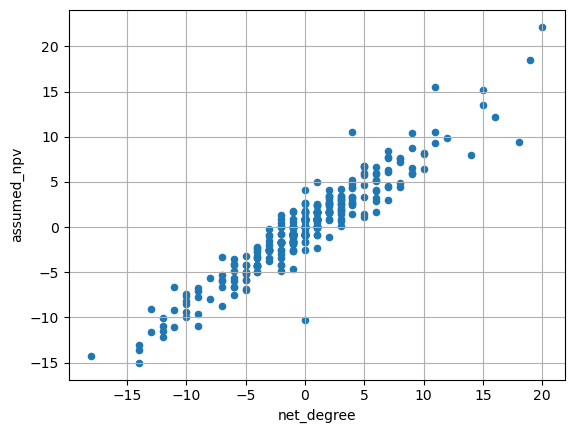

In [37]:
# distributions

import matplotlib.pyplot as plt


results_df.plot.scatter(y='assumed_npv', x='net_degree', grid=True)